<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/FCN_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [2]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 32.4 MB/s 
     |████████████████████████████████| 81 kB 11.8 MB/s 
     |████████████████████████████████| 210 kB 75.6 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 147 kB 69.0 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 112 kB 73.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=e369bf69cda8bc3a50b10e5bd0c88a0401bed36da1ba479e7a5e80045efe1614
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unin

In [3]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [4]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [ ]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [ ]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [ ]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

In [ ]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [ ]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [ ]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [ ]:
print(X_test.shape, y_test.shape)

In [ ]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

 ## Data Loader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [ ]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

In [ ]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

## deep learning model

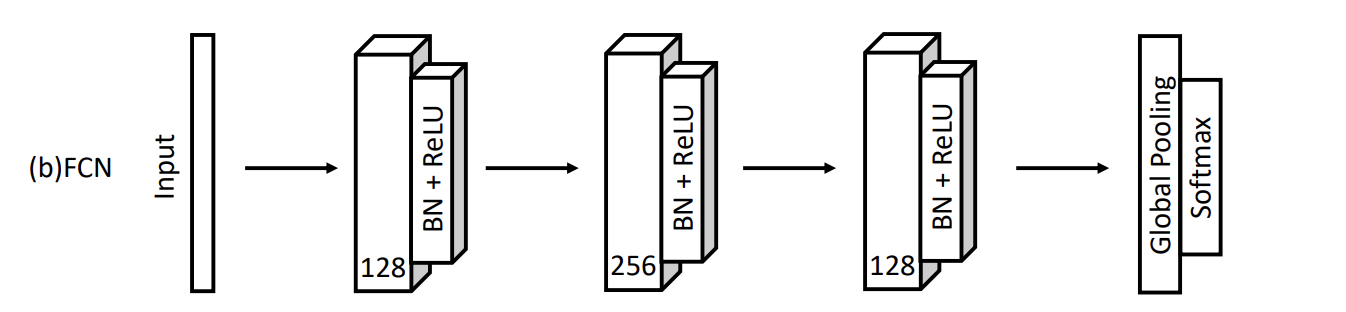

The follwoing code includes Batch Normalaization in each block and Global pooling layer at the end the structure. However, I inactivated these sections a and run the model(those sections worsens the result)

In [ ]:
#here is the code for a ConvBlock
#batch-normalization is removerd from the code becasue it worsens the results.

class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks, drop=0.):
        super(ConvBlock, self).__init__()

        self.conv1d = nn.Conv1d(ni,nf,ks)
        self.dropout = nn.Dropout(drop)
        self.batch_norm = nn.BatchNorm1d(nf)
        self.relu = nn.ReLU()
        self.cpad1d = nn.ConstantPad1d(((ks-1), 0), 0)  
        self.init_weights

    def init_weights(self):
        self.conv1d.weight.data.normal_(0, 0.01)

    def forward(self, x):
        x = self.cpad1d(self.conv1d(x))
        x = self.dropout(x)
        #x = self.batch_norm(x)  #batch normalization
        x = self.relu(x)
        return x

In [ ]:
#for testing the dimension of ConvBlock
#x = torch.rand(64, 9,120)
#model = ConvBlock(ni = 9,
#                nf =64, 
#                ks = 9)

#y = model(x)
#y.shape

In [ ]:
#making a global average plooing layer
class GlobalAveragePooling1D(nn.Module):
    def __init__(self, data_format='channels_last'):
        super(GlobalAveragePooling1D, self).__init__()

        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.mean(input, axis=self.step_axis)

In [ ]:
class FCN(nn.Module):
    def __init__(self, c_in, c_out, seq_len, layers=[128, 256, 128], kss=[7, 5, 3]):
        super(FCN, self).__init__()
        assert len(layers) == len(kss)

        self.convblock1 = ConvBlock(c_in, layers[0], kss[0])
        self.convblock2 = ConvBlock(layers[0], layers[1], kss[1])
        self.convblock3 = ConvBlock(layers[1], layers[2], kss[2])
        self.GAP1D = GlobalAveragePooling1D()
        self.fc = nn.Linear(layers[-1]*seq_len, c_out) #**NOTE:if you activate the GAP layer, remove 'seq_len' from the linear layer
    def forward(self, x):
        x = x.permute(0, 2, 1)
        #print(x.shape)
        x = self.convblock1(x)
        #print(x.shape)
        x = self.convblock2(x)
        #print(x.shape)
        x = self.convblock3(x)
        x = x.permute(0, 2, 1)
        #print(x.shape)
        out = torch.flatten(x, start_dim=1)    #**NOTE:if you activate the GAP layer, deactive the layer
        #out = self.GAP1D(x)
        return self.fc(out)

In [ ]:
#checking dimensions of FCN layers
#x = torch.rand(64, 120, 9)
#model = FCN(c_in = 9,
#            seq_len = 120, 
#            layers=[128, 256, 128],
#            kss=[7, 5, 3],
#            c_out=24)
#y = model(x)
#y.shape

In [ ]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf


    # Generate the model.
    model = FCN(c_in = 9, 
                seq_len=120,
                layers=[128, 256, 128],
                kss=[7, 5, 3],
                c_out=24).cuda()
                #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "TCN_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [67]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-25 18:57:15,821] A new study created in memory with name: no-name-aa59e910-ccdb-480a-8917-77e988849f00


Iter:  0 train:  208.75545552372932 val:  33.2230675406754
Iter:  20 train:  7.731095219962299 val:  41.40676228515804


[I 2022-12-25 18:58:46,474] Trial 0 finished with value: 28.882612120360136 and parameters: {'lr': 0.0006067578710176238}. Best is trial 0 with value: 28.882612120360136.


Iter:  0 train:  337.35173738002777 val:  41.6516299135983
Iter:  20 train:  39.949416652321815 val:  28.640039287507534
Iter:  40 train:  20.24894455447793 val:  35.972146509215236


[I 2022-12-25 19:01:35,227] Trial 1 finished with value: 27.309894045814872 and parameters: {'lr': 2.7451114456224028e-05}. Best is trial 1 with value: 27.309894045814872.


Iter:  0 train:  265.9477540999651 val:  43.540438855066895
Iter:  20 train:  21.715723859146237 val:  33.892490638419986


[I 2022-12-25 19:03:30,748] Trial 2 finished with value: 26.756386613473296 and parameters: {'lr': 5.574534712811409e-05}. Best is trial 2 with value: 26.756386613473296.


Iter:  0 train:  226.29484789818525 val:  32.146569857373834
Iter:  20 train:  9.076781726442277 val:  41.06685554608703


[I 2022-12-25 19:05:00,802] Trial 3 finished with value: 27.551994802430272 and parameters: {'lr': 0.0006673182280342886}. Best is trial 2 with value: 26.756386613473296.


Iter:  0 train:  399.3760614693165 val:  44.34085520543158
Iter:  20 train:  43.117003601044416 val:  28.260755261406302


[I 2022-12-25 19:07:32,488] Trial 4 finished with value: 26.432356983423233 and parameters: {'lr': 2.3626991995692676e-05}. Best is trial 4 with value: 26.432356983423233.


Iter:  0 train:  254.8227658495307 val:  38.07486577518284


[I 2022-12-25 19:08:08,321] Trial 5 pruned. 


Iter:  0 train:  324.6028907299042 val:  42.44345766492188


[I 2022-12-25 19:08:36,237] Trial 6 pruned. 


Iter:  0 train:  220.78916166722775 val:  34.71157699637115


[I 2022-12-25 19:09:04,372] Trial 7 pruned. 


Iter:  0 train:  186.66786275804043 val:  30.85977553203702


[I 2022-12-25 19:09:43,942] Trial 8 pruned. 


Iter:  0 train:  230.9053075313568 val:  34.20508126914501


[I 2022-12-25 19:10:11,860] Trial 9 pruned. 


Iter:  0 train:  632.6214130222797 val:  54.835931446403265


[I 2022-12-25 19:10:39,789] Trial 10 pruned. 


Iter:  0 train:  527.4437067359686 val:  52.55141510441899


[I 2022-12-25 19:11:07,681] Trial 11 pruned. 


Iter:  0 train:  336.9983307942748 val:  40.94105361402035


[I 2022-12-25 19:11:35,864] Trial 12 pruned. 


Iter:  0 train:  185.3572150543332 val:  32.77450686972588


[I 2022-12-25 19:12:07,517] Trial 13 pruned. 


Iter:  0 train:  301.0314743369818 val:  40.65606750547886


[I 2022-12-25 19:12:39,274] Trial 14 pruned. 


Iter:  0 train:  448.1114773899317 val:  46.378663528710604


[I 2022-12-25 19:13:07,198] Trial 15 pruned. 


Iter:  0 train:  402.2643231600523 val:  48.681661404669285


[I 2022-12-25 19:13:35,099] Trial 16 pruned. 


Iter:  0 train:  193.5237170010805 val:  37.633804485201836


[I 2022-12-25 19:14:07,056] Trial 17 pruned. 


Iter:  0 train:  170.96610610932112 val:  30.320326924324036


[I 2022-12-25 19:14:34,646] Trial 18 pruned. 


Iter:  0 train:  277.8213976621628 val:  36.35064708441496


[I 2022-12-25 19:15:10,492] Trial 19 pruned. 


Iter:  0 train:  258.178632222116 val:  36.450894460082054
Iter:  20 train:  21.804425805807114 val:  36.618754506111145


[I 2022-12-25 19:16:46,037] Trial 20 pruned. 


Iter:  0 train:  367.1768337339163 val:  44.144452691078186


[I 2022-12-25 19:17:13,877] Trial 21 pruned. 


Iter:  0 train:  366.04057348519564 val:  47.069319766014814


[I 2022-12-25 19:17:41,778] Trial 22 pruned. 


Iter:  0 train:  460.8804083764553 val:  63.57633834332228


[I 2022-12-25 19:18:09,599] Trial 23 pruned. 


Iter:  0 train:  295.8254760876298 val:  38.966367242857814


[I 2022-12-25 19:18:37,448] Trial 24 pruned. 


Iter:  0 train:  383.8562423437834 val:  43.87550791166723


[I 2022-12-25 19:19:05,540] Trial 25 pruned. 


Iter:  0 train:  633.8046069890261 val:  56.52089847996831


[I 2022-12-25 19:19:33,448] Trial 26 pruned. 


Iter:  0 train:  241.06672796607018 val:  34.99888615310192
Iter:  20 train:  14.137729434296489 val:  38.0073710065335


[I 2022-12-25 19:21:08,644] Trial 27 pruned. 


Iter:  0 train:  205.60554445534945 val:  34.896869676187634


[I 2022-12-25 19:21:48,538] Trial 28 pruned. 


Iter:  0 train:  158.8453835323453 val:  31.91416623815894


[I 2022-12-25 19:22:16,049] Trial 29 pruned. 


Iter:  0 train:  289.8857947513461 val:  41.84620876610279


[I 2022-12-25 19:22:47,885] Trial 30 pruned. 


Iter:  0 train:  137.65329659730196 val:  28.890518076717854
Iter:  20 train:  8.698204431682825 val:  37.8277755882591


[I 2022-12-25 19:24:13,607] Trial 31 finished with value: 27.28583333455026 and parameters: {'lr': 0.0008538637840087432}. Best is trial 4 with value: 26.432356983423233.


Iter:  0 train:  153.83665788918734 val:  33.42399804294109


[I 2022-12-25 19:24:40,809] Trial 32 pruned. 


Iter:  0 train:  177.06884087622166 val:  41.051206678152084


[I 2022-12-25 19:25:08,245] Trial 33 pruned. 


Iter:  0 train:  183.3325179517269 val:  35.80670718103647


[I 2022-12-25 19:25:35,792] Trial 34 pruned. 


Iter:  0 train:  492.5162506252527 val:  52.43783365562558


[I 2022-12-25 19:26:03,688] Trial 35 pruned. 


Iter:  0 train:  212.43524771928787 val:  41.958061307668686


[I 2022-12-25 19:26:51,464] Trial 36 pruned. 


Iter:  0 train:  258.0821693018079 val:  43.27622225321829
Iter:  20 train:  18.72015331685543 val:  33.12224568426609


[I 2022-12-25 19:28:38,543] Trial 37 finished with value: 24.774044658988714 and parameters: {'lr': 6.088861290468902e-05}. Best is trial 37 with value: 24.774044658988714.


Iter:  0 train:  264.13423857837915 val:  35.76576676592231


[I 2022-12-25 19:29:06,570] Trial 38 pruned. 


Iter:  0 train:  235.93713177740574 val:  38.80247964896262


[I 2022-12-25 19:29:46,211] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  33
  Number of complete trials:  7
Best trial:
  Value:  24.774044658988714
  Params: 
    lr: 6.088861290468902e-05


<ipython-input-77-daaa700951ce>:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=[ "lr" ])


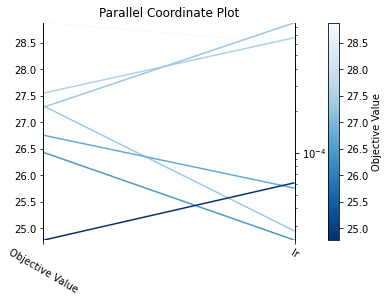

In [77]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=[ "lr" ])
optuna.visualization.plot_param_importances(study)

In [76]:
#Download the PT file
from google.colab import files
files.download('TCN_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
#Read the pk file
model = FCN(c_in = 9, 
                seq_len=120,
                layers=[128, 256, 128],
                kss=[7, 5, 3],
                c_out=24)

model.load_state_dict(torch.load("TCN_BO.pt"))

<All keys matched successfully>

In [69]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [70]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [72]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x
        batch_y = batch_y
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   153.68522098080717
R^2                :        0.9550245268677278
Mean Absolute Error:        125.41248659088939
MAPE               :        0.0203304128223249


error for next 2 hour prediction
Root Mean Squared Error :   153.85550029653095
R^2                :        0.9538494675069882
Mean Absolute Error:        123.42979585644937
MAPE               :        0.020091244600481256


error for next 3 hour prediction
Root Mean Squared Error :   170.1657393970965
R^2                :        0.9436878341076707
Mean Absolute Error:        137.02384823866592
MAPE               :        0.022235110005509977


error for next 24 hour prediction
Root Mean Squared Error :   234.79441978836383
R^2                :        0.8788129384938321
Mean Absolute Error:        188.95064634622054
MAPE               :        0.03129764526538251


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


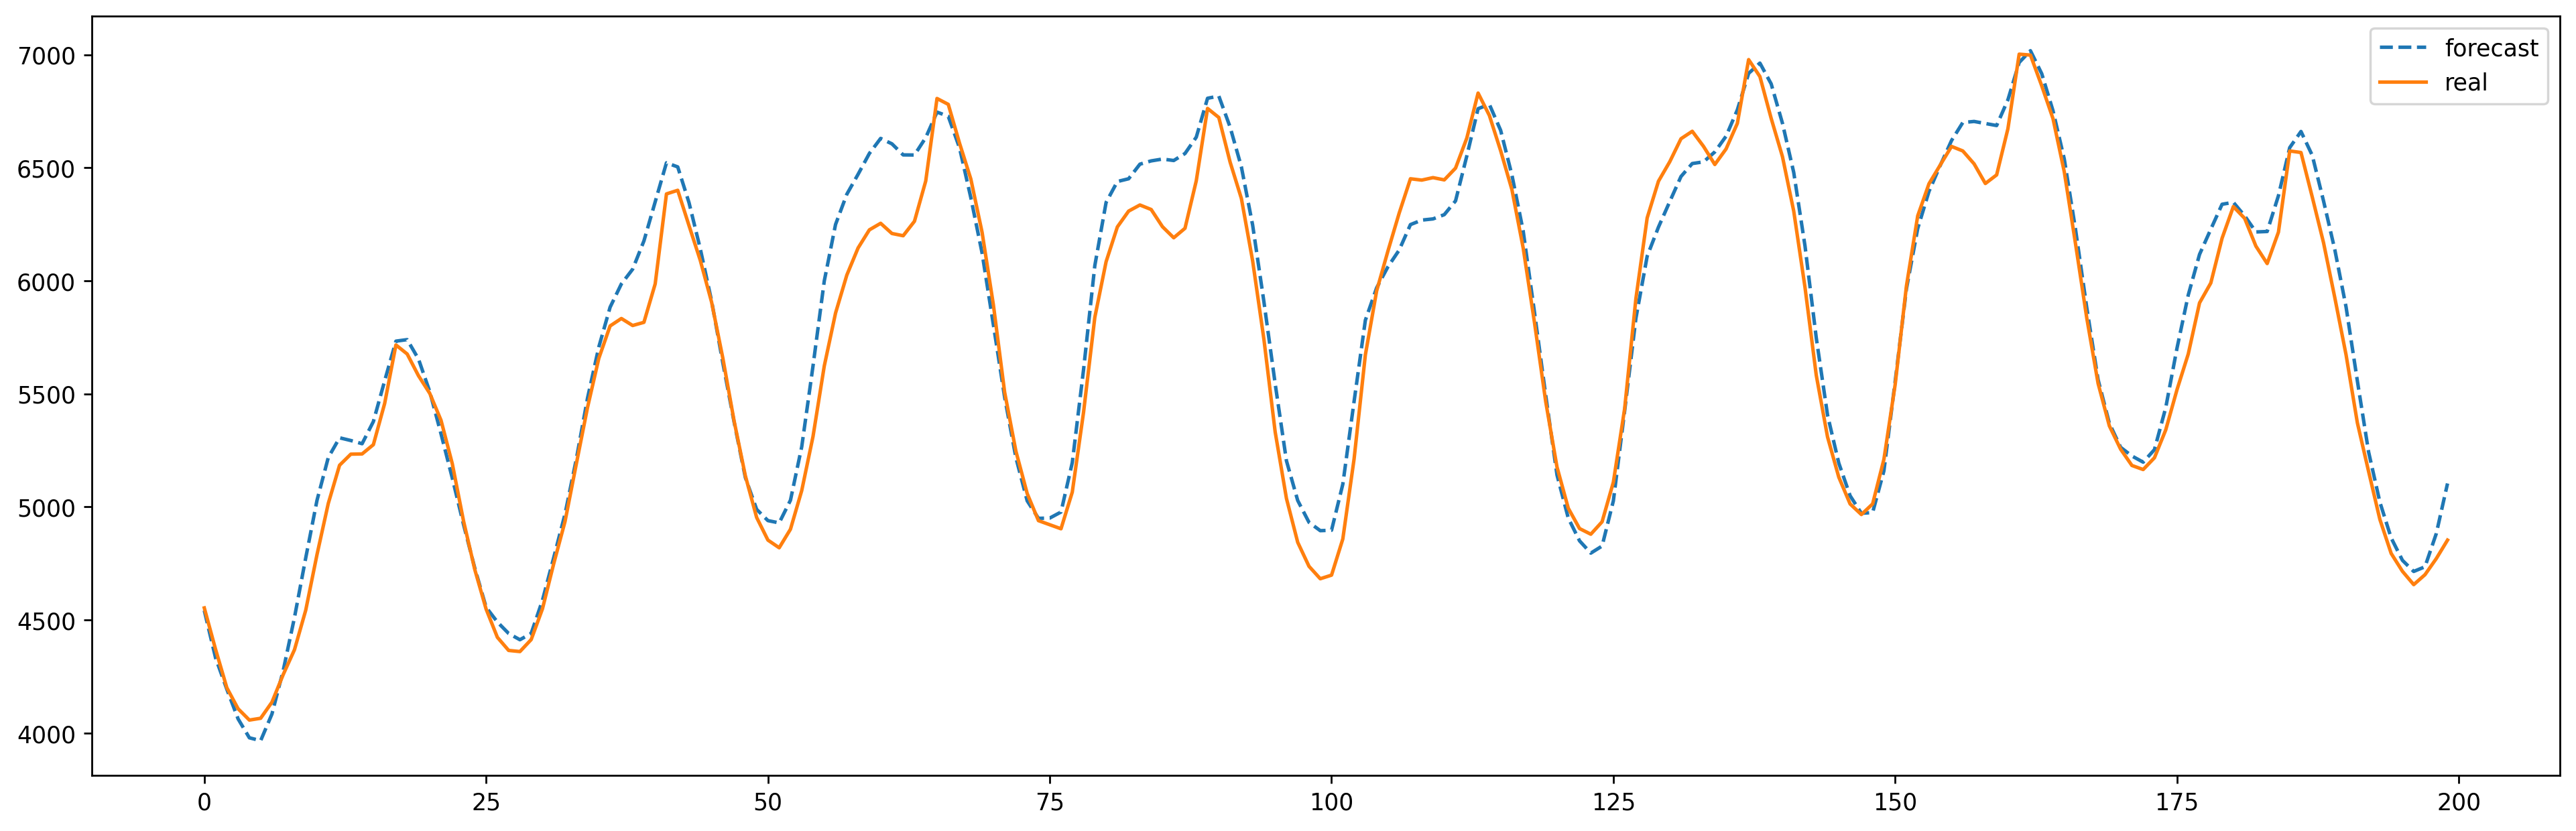

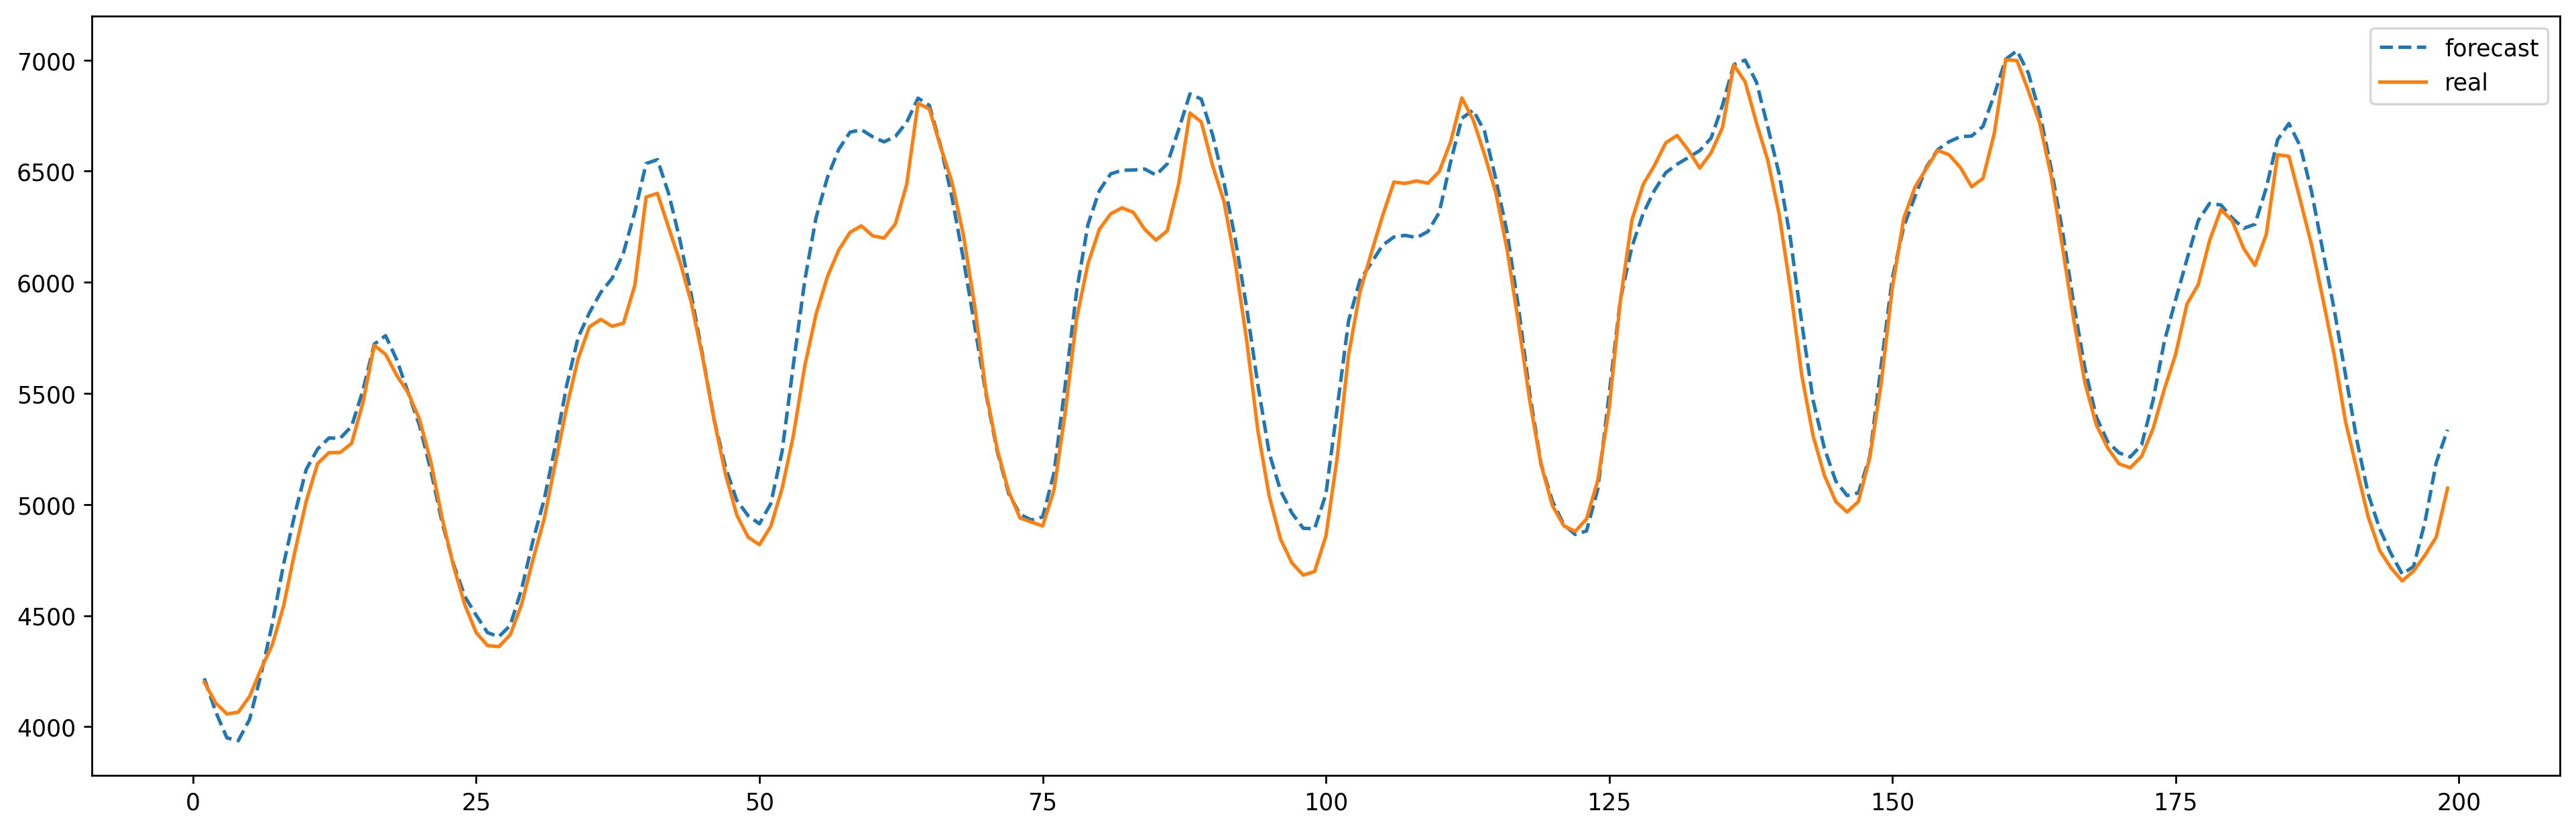

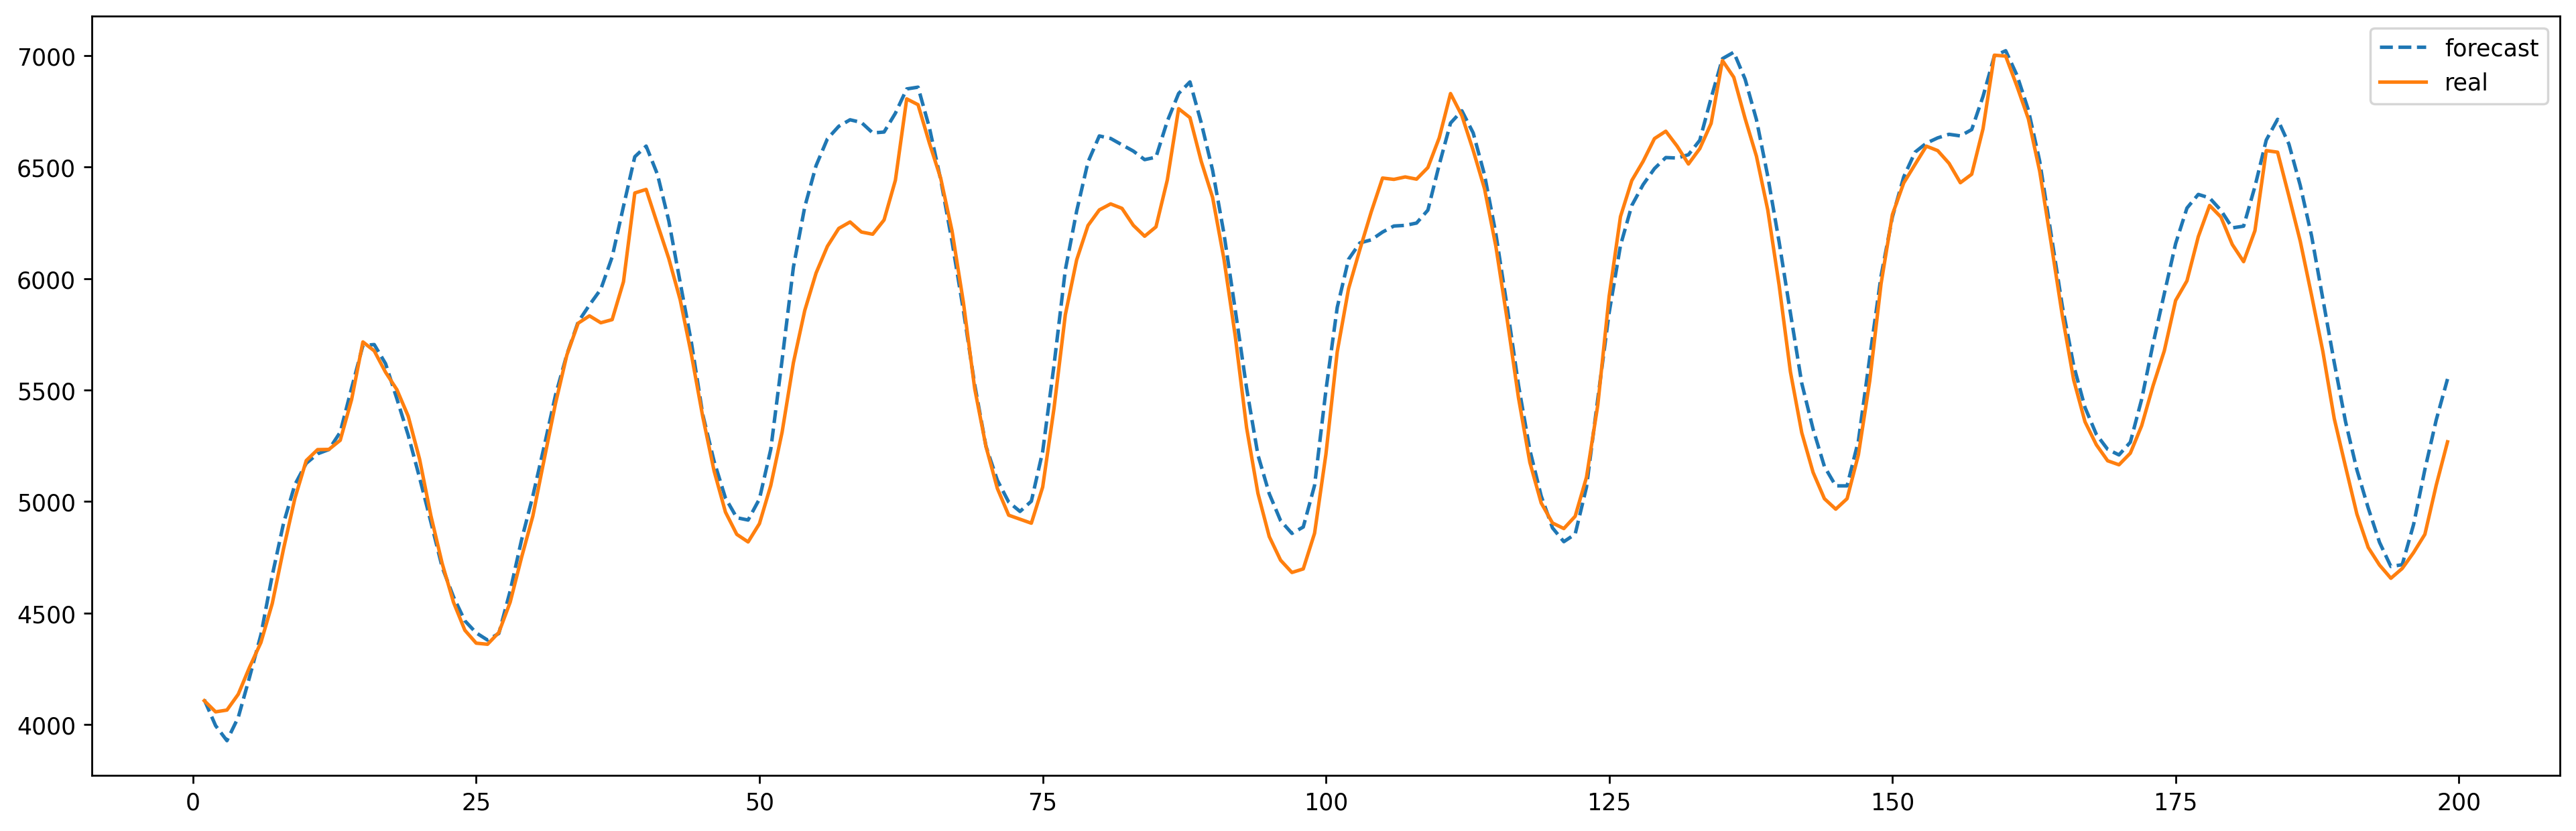

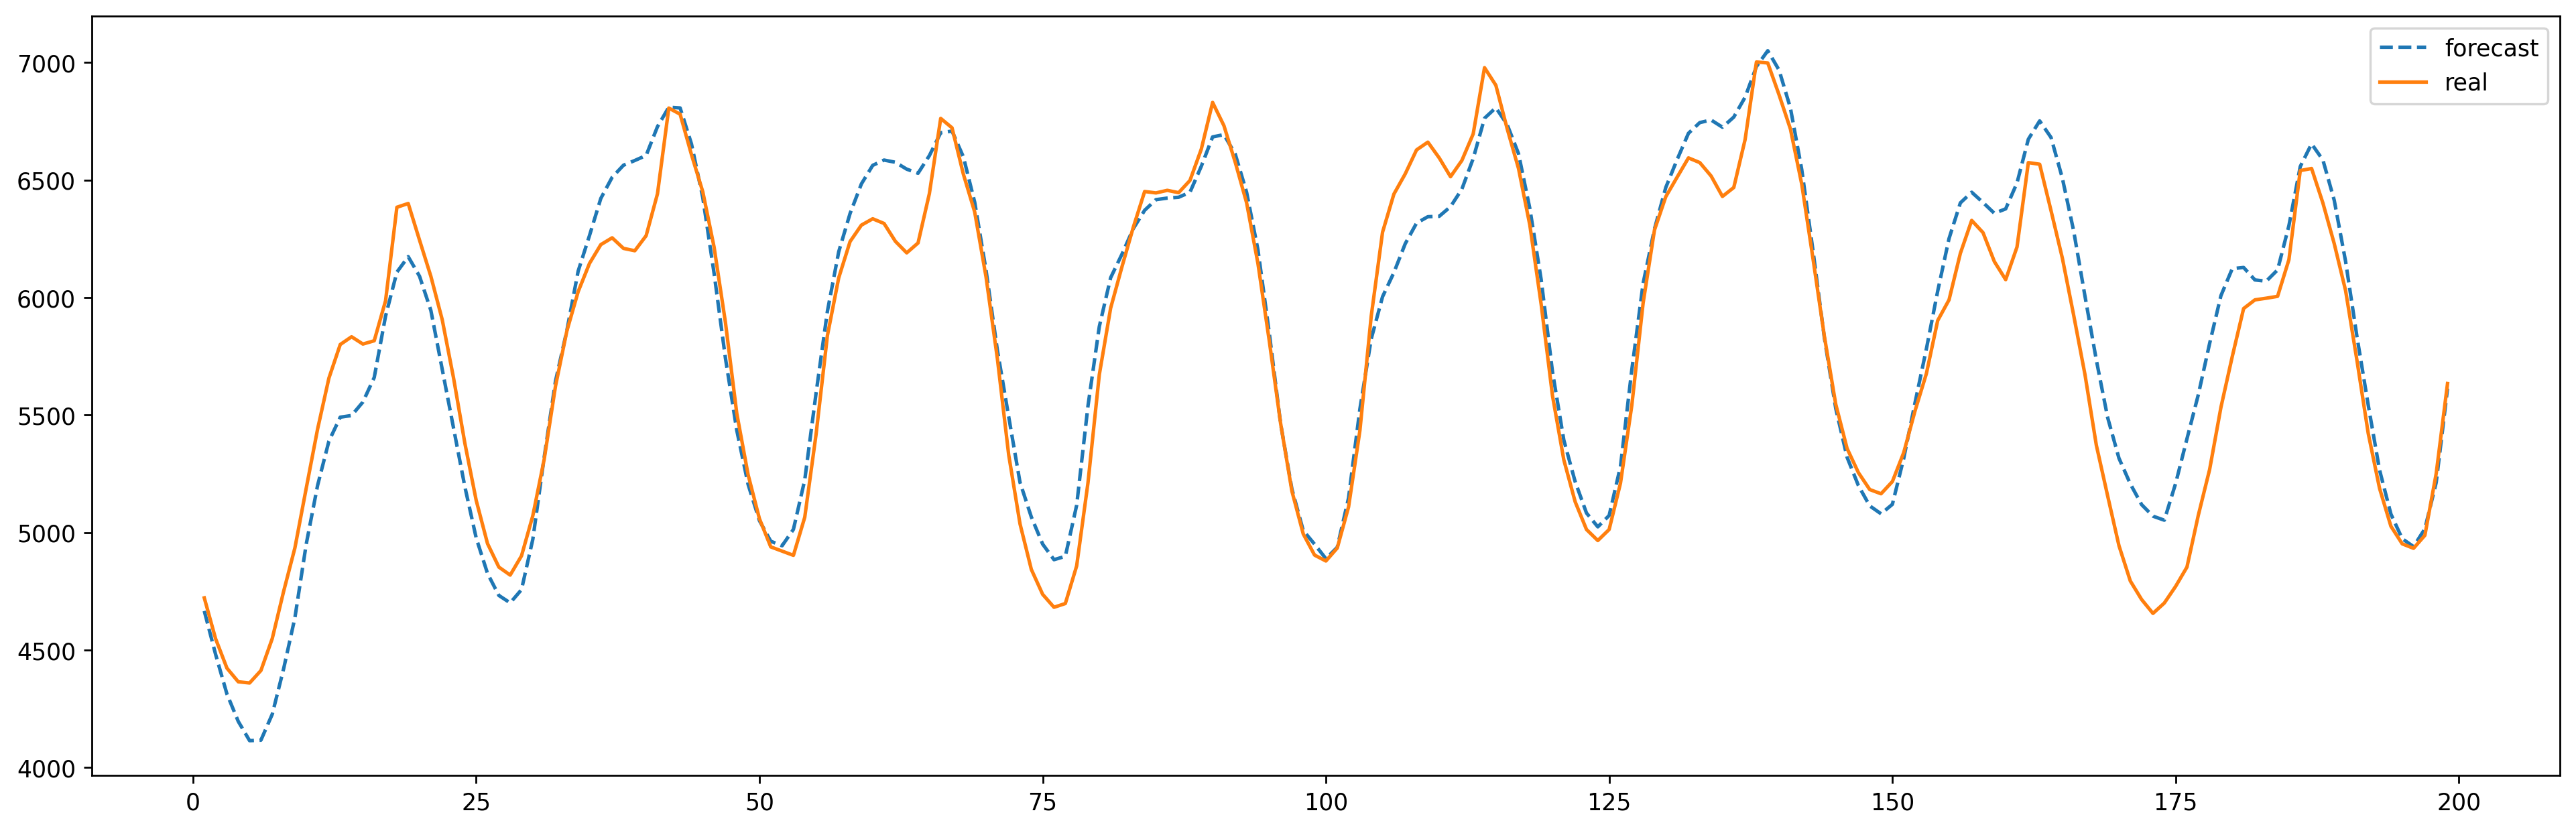

In [73]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [74]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

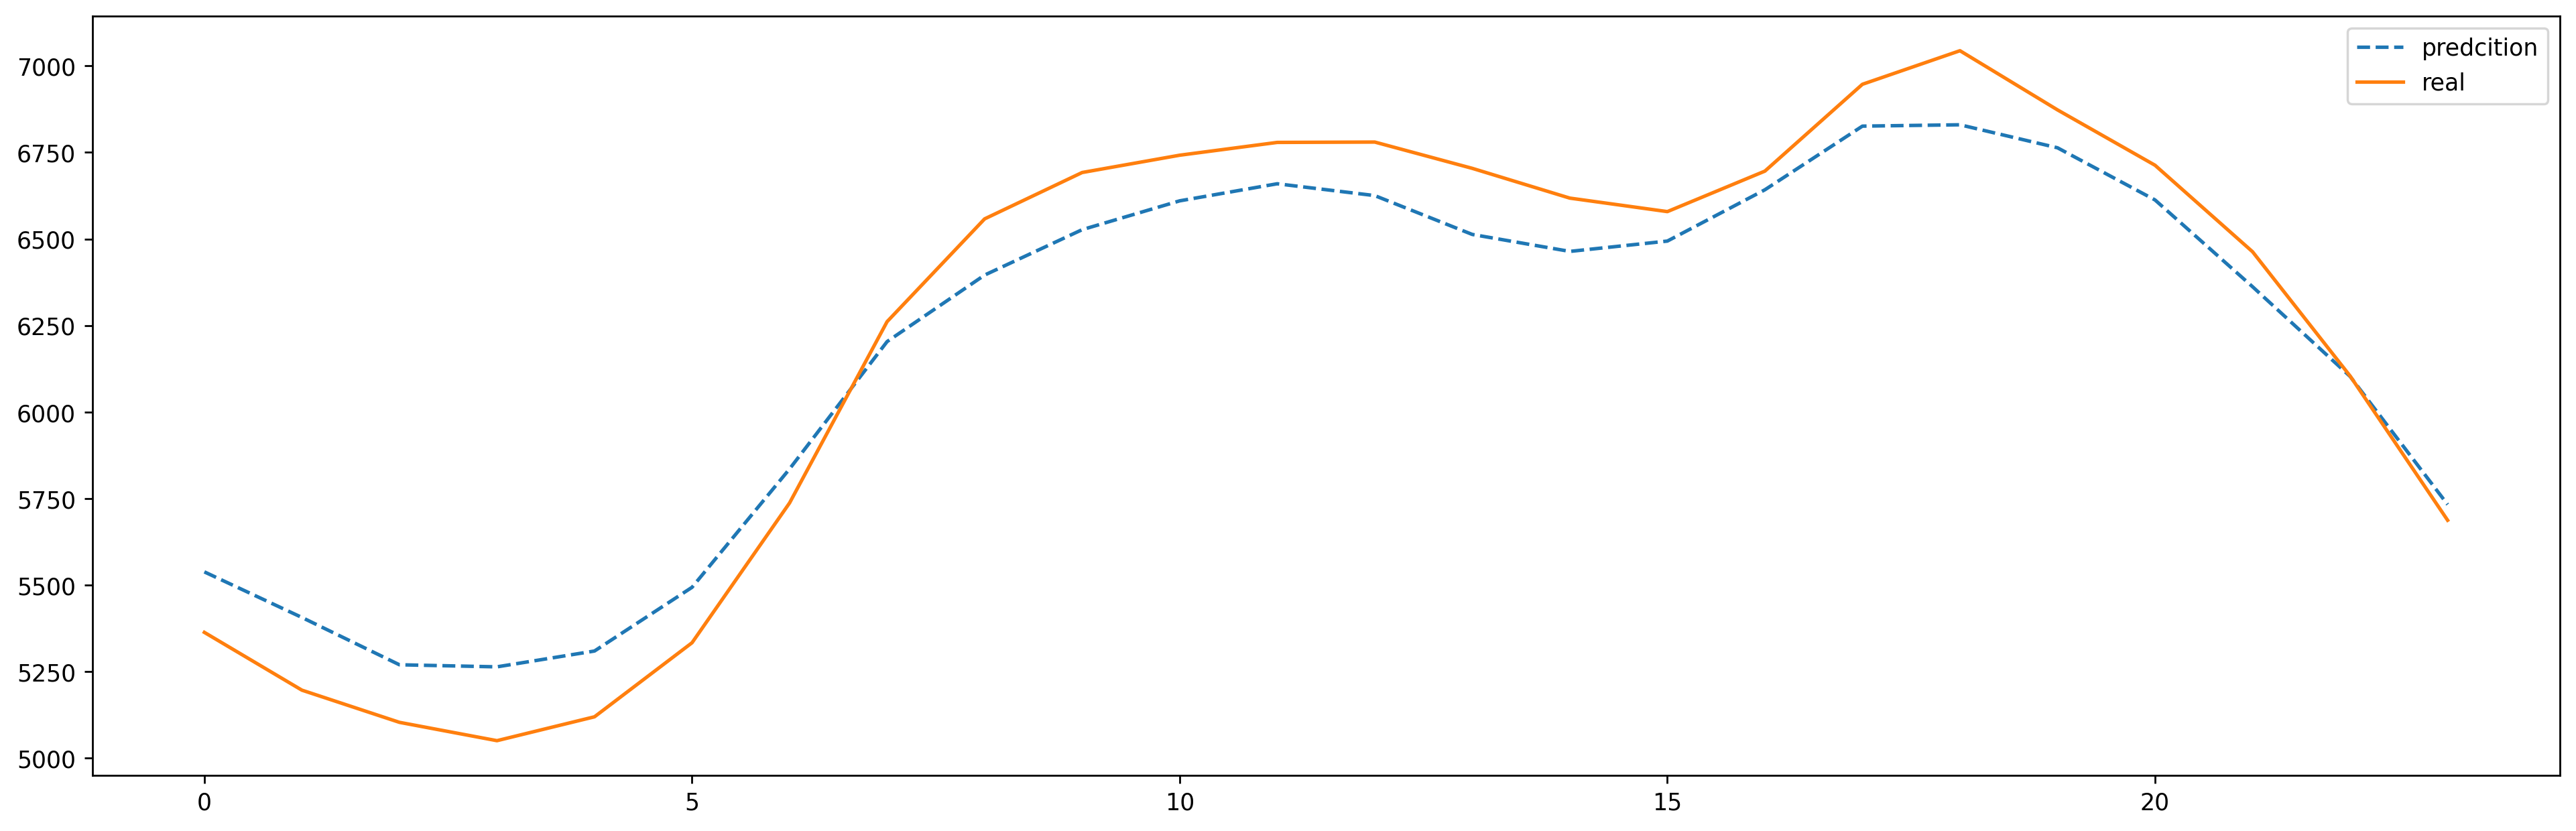

In [75]:
figure(figsize=(19, 6), dpi=250)

j=30*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
